<a href="https://colab.research.google.com/github/pachterlab/FGP_2023/blob/main/noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Noise Implementation
In this notebook we show how we implement noise. The functions are also included in noise.py for import into other notebooks.

In [25]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

from FGP_2023.noise import *
from FGP_2023.simulation import analytic_ss

import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Fuctions for applying random drop-out to simulated data.

In [22]:
def get_combos(n):
    '''
    Create list of possible site configurations for an n-site locus.

    Args:
        n (int): number of sites in locus

    Output:
        list of site-openness configurations, e.g. [[0,0], [1,0], [0,1], [1,1]] for a six-site locus
        N.B. these configurations are ordered in the basis of the transition matrix in construct_H.py.
    '''

    combos = basis_sort(create_binaries(n))

    return combos

def apply_dropout(site_configs, pdrop):
    '''
    Apply random binomial dropout to a sample of site configurations.

    Args:
        site_configs (list of list of ints): list of site configurations --
            each site configuration is a list of site-openness values at each site in locus
            e.g. [[1,0,1], [0,0,0]] for two samples at a three-site locus
        pdrop (float): probability of dropout at each site

    Output:
        new site configurations after random dropout, e.g. [[0,0,1], [0,0,0]]
    '''
    new_configs = []
    for site_config in site_configs:
      new_state = site_config.copy()
      for j in range(len(site_config)):
          kept = np.random.binomial(1, 1-pdrop)
          if not kept:
            new_state[j] = 0
      new_configs += [new_state]

    return new_configs

def list_configs(simulated_cells, n):
    '''
    Generate list of locus configurations from the output of simulation.py

    Args:
      simulated_cells (array): chromatin-state and RNA information for cells over time
          Each cell is of the form [[2^n-length chromatin vector], [n-length transcript vector]]
      n (int): number of sites in locus

    Output:
      list of site configurations for each cell at the final time point of the simulation
      e.g. [[1,0], [1,0], [0,0]] for 3 cells in a two-site system
    '''
    final_chromatin_state_vectors = simulated_cells[:,-1,:-n]
    combos = get_combos(n)

    # Convert from chromatin state vectors to state indices. e.g. [0,0,1,0] -> 2
    state_indices = [list(cell).index(1) for cell in final_chromatin_state_vectors]

    # Convert to lists of site openness.
    site_configs = [combos[i] for i in state_indices]

    return site_configs


def dist_from_samples(site_configs):
    '''
    Return probability distribution given list of site configurations.

    Args:
        site_configs (list of lists of ints): configuration of sites for each cell
            e.g. [[1,1,1], [0,0,1]] for a two-cell sample of three-site loci

    Output:
        probability distribution of form {(config): prob}
            e.g. {(0,0): 0.5, (0,1): 0.2, (1,0): 0.2, (1,1):0.1} for a two-site locus
    '''

    n = len(site_configs[0])
    config_tuples = [tuple(config) for config in site_configs]
    counter = Counter(config_tuples)

    # Normalize distribution.
    total_cells = sum(counter.values())
    config_distribution = {k:v/total_cells for k, v in counter.items()}

    return config_distribution

100%|██████████| 10000/10000 [00:12<00:00, 820.24it/s]


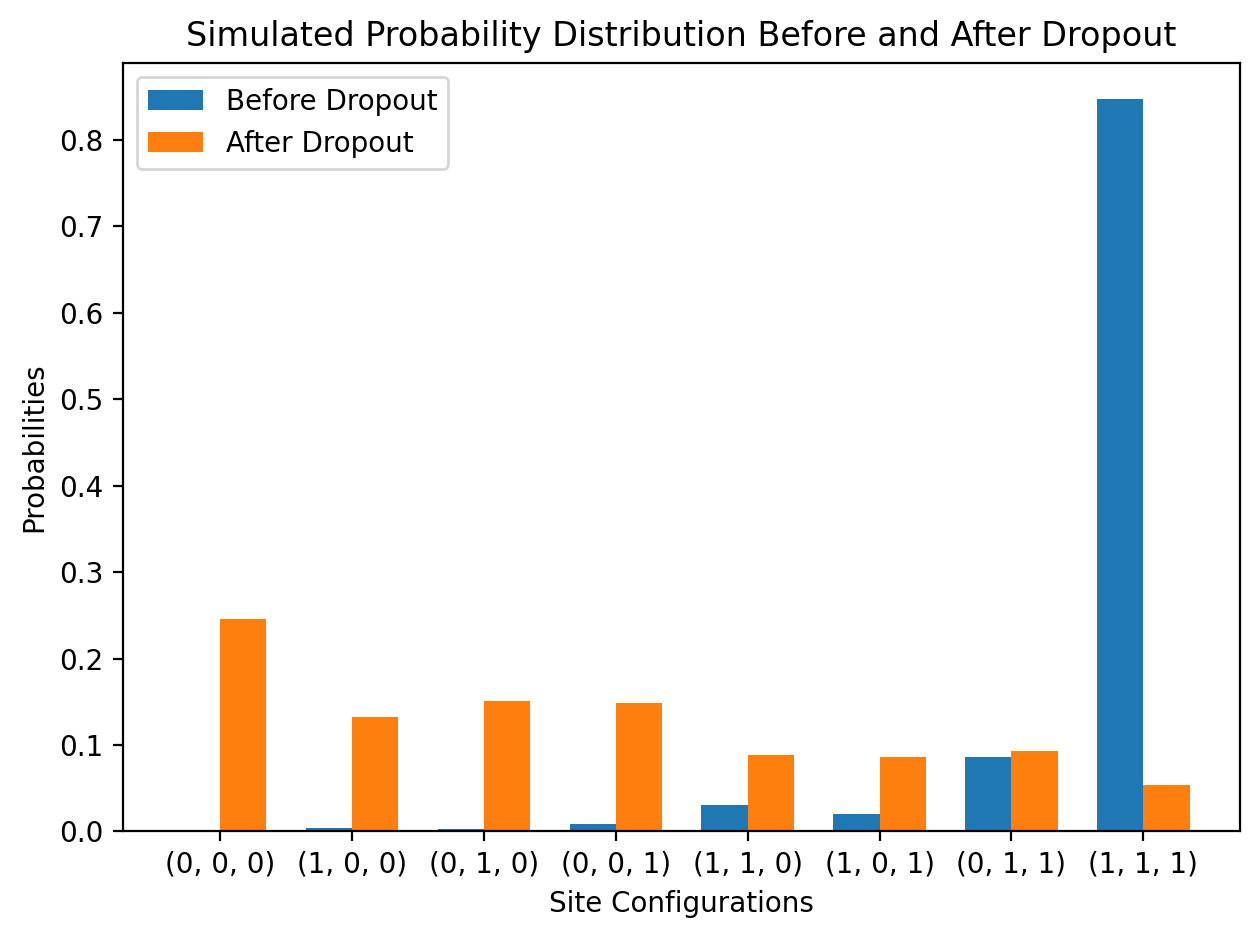

In [41]:
## Simulate cells.

k_ons, k_off, epsilon, noise, nCells = [1,2,3], .2, 0.5, 0.5, 10000
n = len(k_ons)

# ATAC only simulation.
bs = [0]*n
ds = [0]*n

simulation_time =  5/min(k_ons)

simulated_cells = create_samples(k_ons, k_off, bs, ds, epsilon, nCells, simulation_time)[1]

# Convert to list of site configurations.
site_configs = list_configs(simulated_cells, n)

# Apply dropout to these loci.
pdrop = 0.6
dropped_site_configs = apply_dropout(site_configs, pdrop)

# Get distributions from these list of site configurations.
simulated_distribution = dist_from_samples(site_configs)
simulated_dropped_dist = dist_from_samples(dropped_site_configs)

# Plot simulated distribution and drop-out distribution.
dict1, dict2 = simulated_distribution, simulated_dropped_dist
keys, values_dict1, values_dict2 = list(dict1.keys()), list(dict1.values()), list(dict2.values())

bar_width = 0.35  # Width of the bars
x_indexes = range(len(keys))  # X-axis indexes for the bars

# Plotting the bars
plt.bar(x_indexes, values_dict1, width=bar_width, label='Before Dropout')
plt.bar([i + bar_width for i in x_indexes], values_dict2, width=bar_width, label='After Dropout')

plt.xlabel('Site Configurations')
plt.ylabel('Probabilities')
plt.title('Simulated Probability Distribution Before and After Dropout')
plt.xticks([i + bar_width / 2 for i in x_indexes], keys)  # Setting x-axis labels
plt.legend()
plt.tight_layout()
plt.show()

## Functions for deterministically updating a probability distribution with the effect of technical noise.

In [42]:
def prob_change(string, drop):
    '''
    Calculates the probability flow from a given configuration to new configurations under drop-out.

    Args:
        string (tuple): The original configuration in the +1/-1 convention.
        drop (float): The drop-out probabilty for an individual site to flip from +1 to -1.

    Returns:
        dictionary: A dictionary whose keys are the possible resulting configurations after drop-out,
            and whose values are the probability of arriving at the new configuration from the old (and
            the negative of the probability of leaving the original configuration for the original configuration)
    '''

    # Identify how many 'on' sites in this configuration.
    on_indices = [i for i in range(len(string)) if string[i]==1]

    # Generate all possible drop-out scenarios. (e.g. all 'on' sites --> 'off', the second 'on' site only --> 'off', etc.)
    n = len(on_indices)
    flipped = []
    for i in range(2**n, 2**(n+1)):
        bin_string = bin(i)[3:]
        flipped += [[int(i) for i in bin_string]]

    # Calculate the probability of each drop-out scenario, and the new configuration which results.
    flipped_patterns = {}
    for f in flipped:
        prob = drop**sum(f)*(1-drop)**(n-sum(f))
        new_string = string.copy()
        for i in range(n):
            if f[i]:
                new_string[on_indices[i]] = 0

        # For the no drop-out scenario, report the negative of the probability of leaving the original configuration.
        if new_string==string:
            flipped_patterns[tuple(new_string)] = -(1 - prob)
        else:
            flipped_patterns[tuple(new_string)] = prob

    return flipped_patterns


def dist_drop(distribution, args, kwargs, drop):
    '''
    Modifies an analytic probabilty distribution with the effect of drop-out.

    Args:
        distribution (function): a function which takes args and kwargs and returns a probability distribution
            in the form of a dictionary, with configuration tuples as keys and probabilites as values.
        args (list): the arguments for the analytic distribution.
        kwargs (dictionary): the key-word arguments for the analytic distribution.
        drop: the drop-out probability.
    '''

    # Start with an analytic distribution.
    current_prob = distribution(*args, **kwargs)
    new_prob = current_prob.copy()

    # For each configuration, calculate the probability flow.
    for tpl in current_prob.keys():
        string = list(tpl)
        flow = prob_change(string, drop)

        # Add the flow from the current string to the new string.
        for new_string, change in flow.items():
            new_prob[tuple(new_string)] += change*current_prob[tpl]

            if new_prob[tuple(new_string)] < 0:
                print('neg prob:', new_prob, )

    return new_prob

### Functions for applying techincal noise implementation to an Ising distribution.

In [ ]:
def Ising_analytic_ss(k_ons, k_off, epsilon):
    '''
    Create probability distribution for site configurations in the Ising model.

    Args:
        Ising model params as used in simulation.py

    Output:
        Probability distribution in form {site_config: probability}
    '''

    n = len(k_ons)

    steady_state = analytic_ss(k_ons, k_off, epsilon)

    combos = get_combos(n)

    Ising_prob = {}

    for i in range(len(combos)):

        Ising_prob[tuple(combos[i])] = steady_state[i]

    return Ising_prob

def Ising_analytic_drop(k_ons, k_off, epsilon, pdrop):
    '''
    Calculate the probability distribution for the Ising-like chromatin model after technical dropout.

    Args:
        transition matrix parameters as in simulation.py
        pdrop: probability of dropout at each site.

    Output:
        probability distribution under dropout in form: {site_config: probability}
    '''

    new_dist = dist_drop(Ising_analytic_ss, [k_ons, k_off, epsilon], {}, pdrop)

    return new_dist

### Create analytic probability distribution under dropout and check that the mean at each site under this distribution is the same as the mean of the sites under the analytical distribution without dropout multiplied by the probability of no dropout. (This is a sanity check).

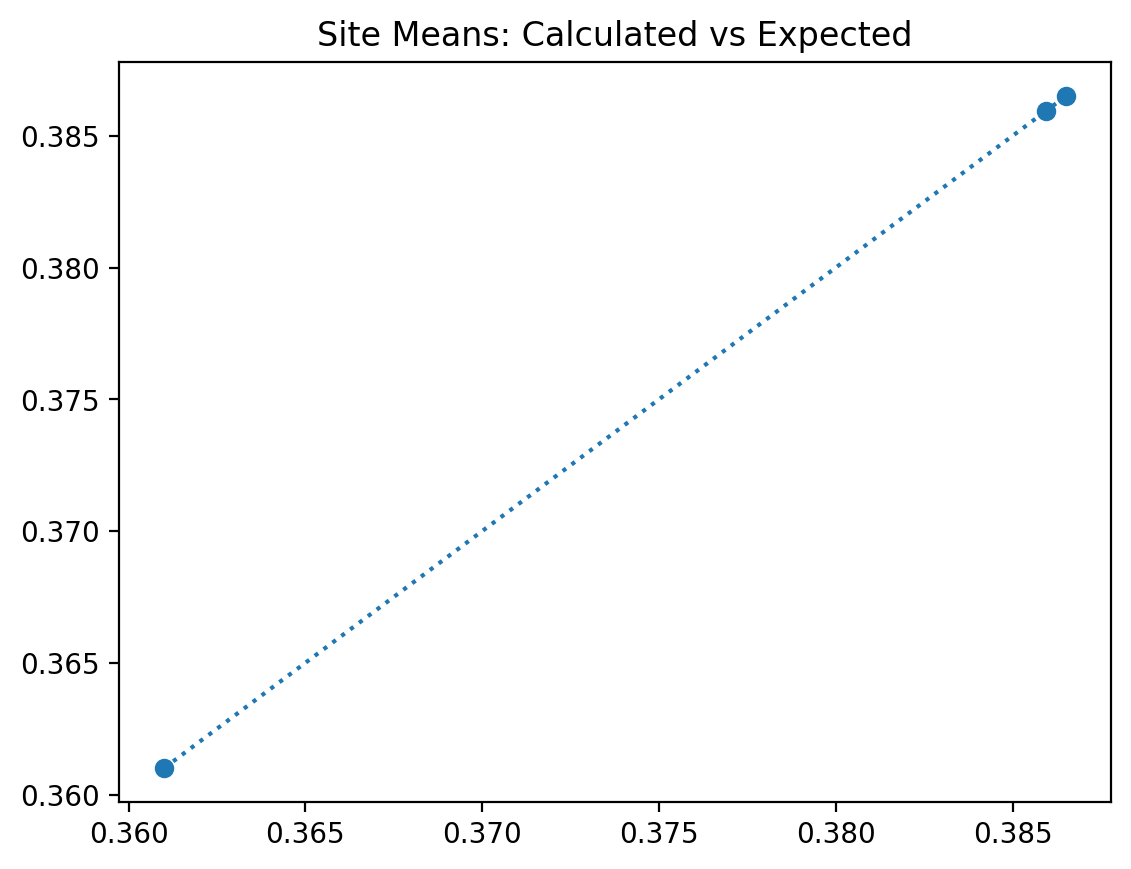

In [55]:
def get_means(distribution):
    '''
    Calculate mean openness for each site from a probability distribution of site configurations.

    Args:
        distribution: probabiltiy distribution of form {site_config: probability}

    Output:
        expected mean at each site.
    '''
    combos = [i for i in distribution.keys()]
    n = len(list(combos[0]))

    means = []
    for i in range(n):
        mean = sum([combo[i]*key for combo, key in distribution.items()])
        means += [mean]

    return means

## Check that dropped analytic solution has the expected means.

# Obtain analytic distribution from applying our noise implementation.
analytic_dropped = Ising_analytic_drop(k_ons, k_off, epsilon, pdrop)
dropped_means = get_means(analytic_dropped)

# Calculate the site-means for the distribution without dropout and multiply by (1-pdrop).
analytic_original = Ising_analytic_ss(k_ons, k_off, epsilon)
expected_means = [(1-pdrop)*mean for mean in get_means(analytic_original)]

plt.title('Site Means: Calculated vs Expected')
# plt.xscale('log')
# plt.yscale('log')

plt.scatter(expected_means, dropped_means)
plt.plot(expected_means, expected_means, linestyle=':')
plt.show()

### Compare the distributions from random dropout on simulated data with the distribution calculated analytically via our deterministic noise implementation.

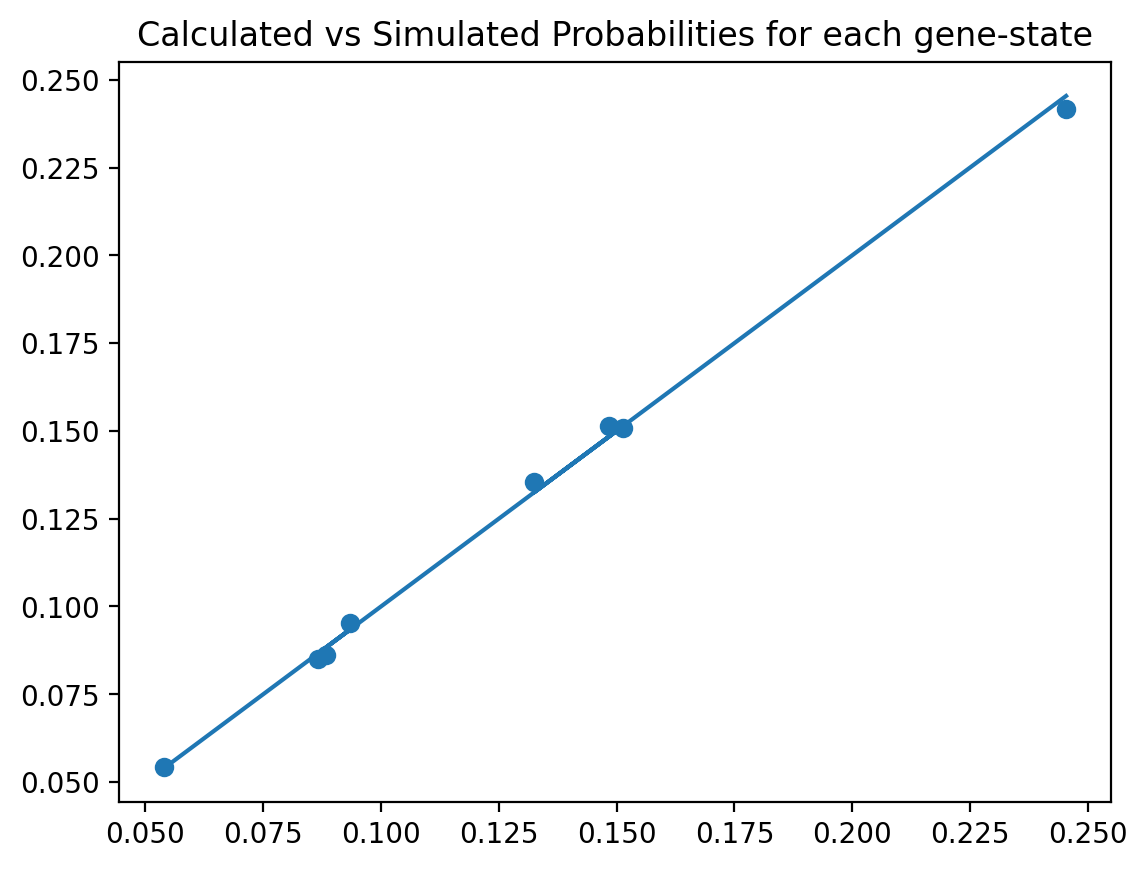

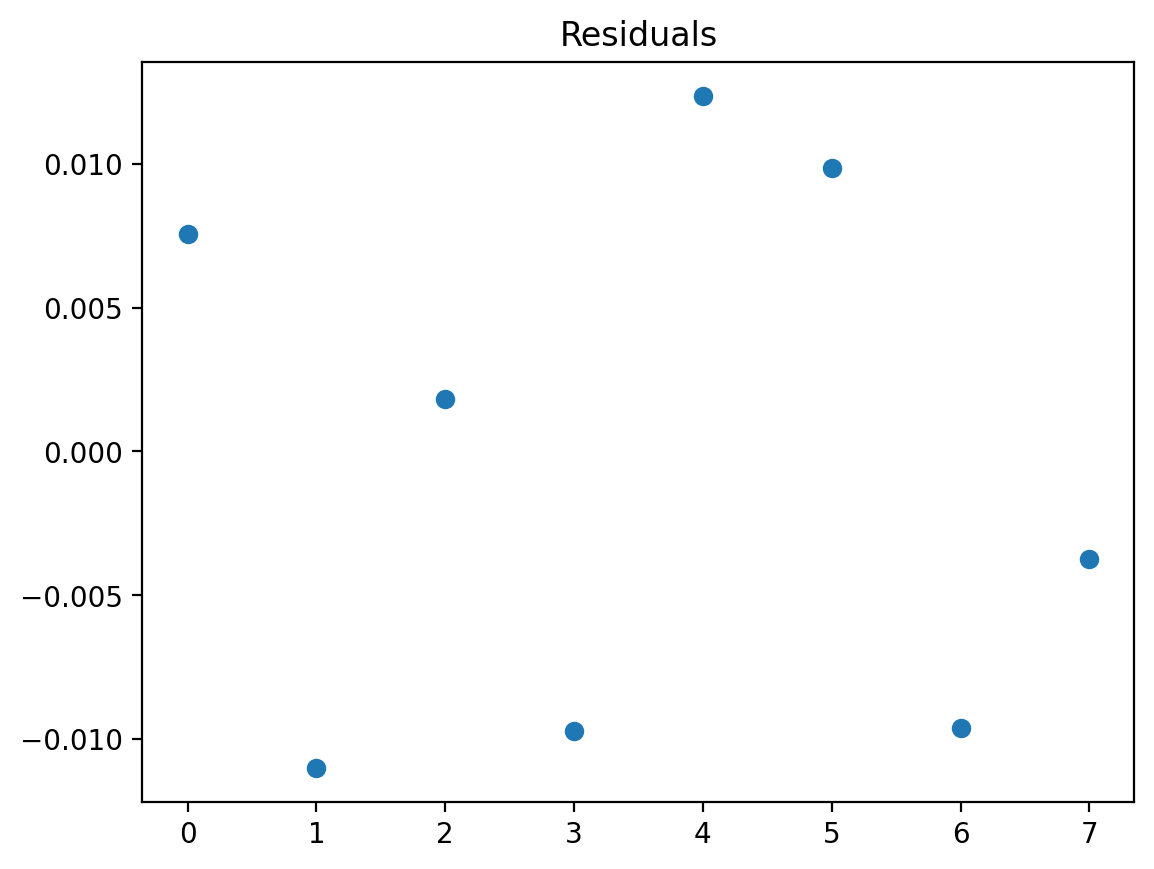

In [50]:
## Check that entire distribution matches between simulation and our noise implementation.

keys = [i for i in simulated_dropped_dist.keys()]
x = [simulated_dropped_dist[i] for i in keys]
y = [analytic_dropped[i] for i in keys]

plt.scatter(x,y)
plt.plot(x,x)
# plt.xscale('log')
# plt.yscale('log')
plt.title('Calculated vs Simulated Probabilities for each gene-state')
plt.show()

## Plot distribution residuals.
residuals = [(i-j)/(i+j) for i, j in zip(x,y)]
plt.scatter([i for i in range(len(x))], residuals)
plt.title('Residuals')
plt.show()